In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Import all data

In [2]:
games = pd.read_csv("C:\\Users\\Ae\\เดสก์ท็อป\\NFL\\games.csv")
players = pd.read_csv("C:\\Users\\Ae\\เดสก์ท็อป\\NFL\\players.csv")
plays = pd.read_csv("C:\\Users\\Ae\\เดสก์ท็อป\\NFL\\plays.csv")
tracking2018 = pd.read_csv("C:\\Users\\Ae\\เดสก์ท็อป\\NFL\\tracking2018.csv")
#tracking2019 = pd.read_csv("C:\\Users\\Ae\\เดสก์ท็อป\\NFL\\tracking2019.csv")
#tracking2020 = pd.read_csv("C:\\Users\\Ae\\เดสก์ท็อป\\NFL\\tracking2020.csv")
#PFFScouting = pd.read_csv('C:\\Users\\Ae\\เดสก์ท็อป\\NFL\\PFFScoutingData.csv')

Function for Downcast
Downcast is a great skill to compress data size which helps to save memory.

In [3]:
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% Compressed'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
def resumetable(df):
    print(f'Shape : {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['Data Type'])
    summary = summary.reset_index()
    summary = summary.rename(columns={'index': 'Feature'})
    summary['Num of null'] = df.isnull().sum().values
    summary['Num of unique'] = df.nunique().values
    summary['First value'] = df.loc[0].values
    summary['Second value'] = df.loc[1].values
    summary['Third value'] = df.loc[2].values
    return summary

In [4]:
games = downcast(games)
players = downcast(players)
plays = downcast(plays)
#tracking2018 = downcast(tracking2018)
#tracking2019 = downcast(tracking2019)
#tracking2020 = downcast(tracking2020)
#PFFScouting = downcast(PFFScouting)

30.3% Compressed
17.8% Compressed
43.0% Compressed


Function for making feature summary

In [5]:
resumetable(players)
resumetable(games)
resumetable(plays)
#resumetable(tracking2018)
#resumetable(tracking2019)
#resumetable(tracking2020)
#resumetable(PFFScouting)

Shape : (2732, 7)
Shape : (764, 7)
Shape : (19979, 25)


Feature Data Type  Num of null  Num of unique  \
0                   gameId     int32            0            764   
1                   playId     int16            0           4435   
2          playDescription    object            0          12355   
3                  quarter      int8            0              5   
4                     down      int8            0              5   
5                yardsToGo      int8            0             38   
6           possessionTeam    object            0             33   
7     specialTeamsPlayType    object            0              4   
8       specialTeamsResult    object            0             12   
9                 kickerId   float32          101            111   
10              returnerId    object        13041            378   
11           kickBlockerId   float32        19879             83   
12            yardlineSide    object          166             33   
13          yardlineNumber      int8            0             50   
14               gameClock    object            0            900   
15            penaltyCodes    object        18877             71   
16    penaltyJerseyNumbers    object        18877            700   
17            penaltyYards   float32        18877             21   
18        preSnapHomeScore      int8            0             54   
19     preSnapVisitorScore      int8            0             55   
20              passResult    object        19934              4   
21              kickLength   float32         3652             79   
22       kickReturnYardage   float32        14655            106   
23              playResult      int8            0            116   
24  absoluteYardlineNumber      int8            0             99   

                                          First value  \
0                                          2018090600   
1                                                  37   
2   J.Elliott kicks 65 yards from PHI 35 to end zo...   
3                                                   1   
4                                                   0   
5                                                   0   
6                                                 PHI   
7                                             Kickoff   
8                                           Touchback   
9                                             44966.0   
10                                                NaN   
11                                                NaN   
12                                                PHI   
13                                                 35   
14                                           15:00:00   
15                                                NaN   
16                                                NaN   
17                                                NaN   
18                                                  0   
19                                                  0   
20                                                NaN   
21                                               66.0   
22                                                NaN   
23                                                 40   
24                                                 45   

                                         Second value  \
0                                          2018090600   
1                                                 366   
2   (9:20) C.Johnston punts 56 yards to ATL 36, Ce...   
3                                                   1   
4                                                   4   
5                                                   4   
6                                                 PHI   
7                                                Punt   
8                                              Return   
9                                             45603.0   
10                                              42450   
11                                                NaN   
12                        

# Game data: The games.csv contains the teams playing in each game. The key variable is gameId.
gameId: Game identifier, unique (numeric)

gameDate: Game Date (time, mm/dd/yyyy)

gameTimeEastern: Start time of game (time, HH:MM:SS, EST)

homeTeamAbbr: Home team three-letter code (text)

visitorTeamAbbr: Visiting team three-letter code (text)

week: Week of game (numeric)

Function for writing percent at the top of the bar graph

In [6]:
def write_percent(ax, total_size):
    '''Traverse the figure object and display the ratio at the top of the bar graph.'''
    for patch in ax.patches:
        height = patch.get_height() # Figure height (number of data)
        width = patch.get_width() # Figure width
        left_coord = patch.get_x() # The x-axis position on the left edge of the figure
        percent = height/total_size*100 # percent
        
        # Type text in the (x, y) coordinates
        ax.text(x=left_coord + width/2.0, # x-axis position
                y=height + total_size*0.001, # y-axis position
                s=f'{percent:1.1f}%', # Text
                ha='center') # in the middle

Make derivative features (month, day, hour) and Data Visualization

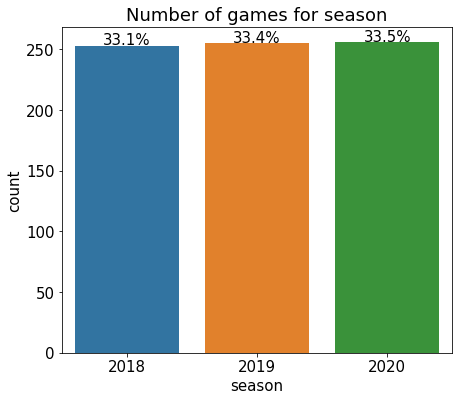

In [7]:
games['month'] = games['gameDate'].apply(lambda x: int(x.split('/')[0]))
games['day'] = games['gameDate'].apply(lambda x: int(x.split('/')[1]))
games['hour'] = games['gameTimeEastern'].apply(lambda x: int(x.split(':')[0]))
mpl.rc('font', size=15) # Set font size
plt.figure(figsize=(7, 6)) # Set figure size

ax = sns.countplot(x='season', data=games)
write_percent(ax, len(games)) 
ax.set_title('Number of games for season');

As the years go by, the number of games increases


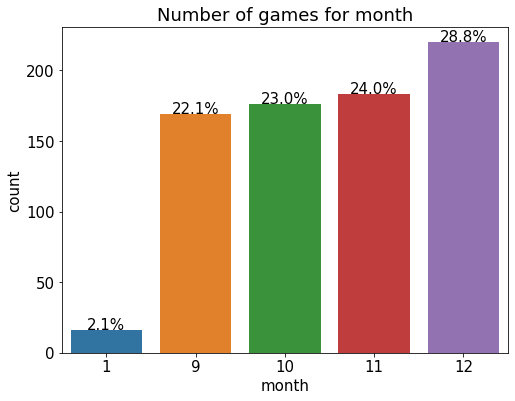

In [8]:
mpl.rc('font', size=15)
plt.figure(figsize=(8, 6))

ax = sns.countplot(x='month', data=games)
write_percent(ax, len(games))
ax.set_title('Number of games for month');

The game was held from September to January. There are especially many games in December, and they are rarely held in January

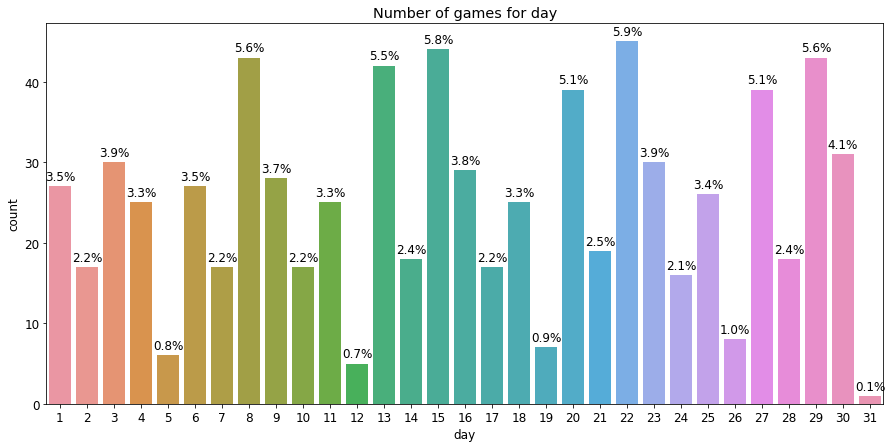

In [9]:
mpl.rc('font', size=12) 
plt.figure(figsize=(15, 7))

ax = sns.countplot(x='day', data=games)
write_percent(ax, len(games))
ax.set_title('Number of games for day');

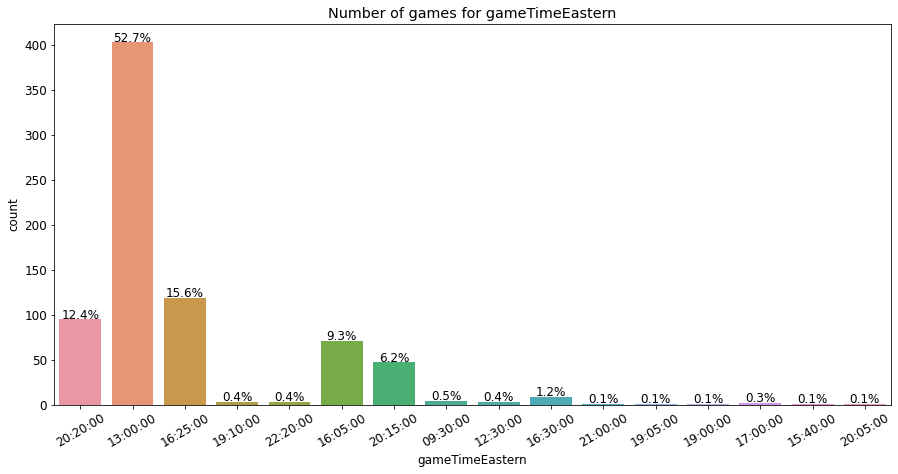

In [10]:
mpl.rc('font', size=12) 
plt.figure(figsize=(15, 7))

ax = sns.countplot(x='gameTimeEastern', data=games)
write_percent(ax, len(games))
ax.set_title('Number of games for gameTimeEastern');
ax.tick_params('x', labelrotation=30) # rotate 30 degree of x label

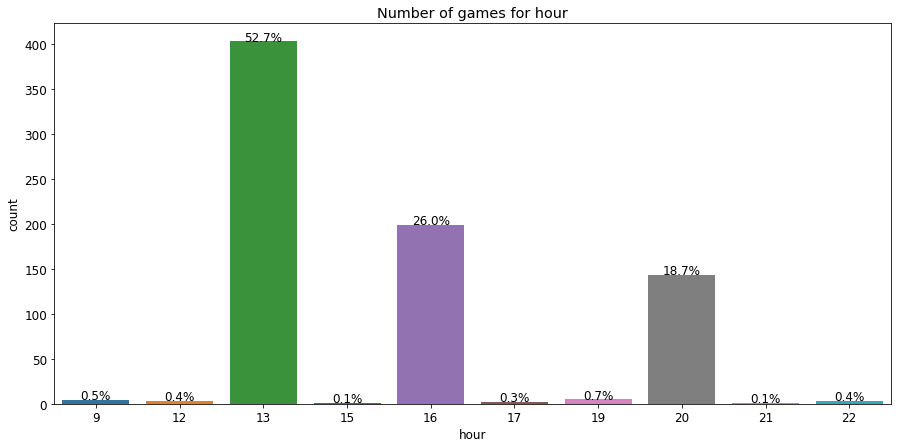

In [11]:
mpl.rc('font', size=12) 
plt.figure(figsize=(15, 7))

ax = sns.countplot(x='hour', data=games)
write_percent(ax, len(games))
ax.set_title('Number of games for hour');

The most games were held at 1, 4, and 8

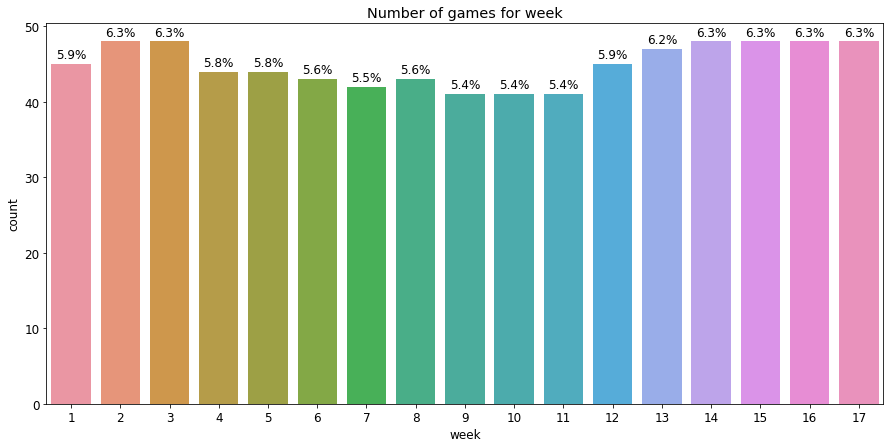

In [12]:
mpl.rc('font', size=12) 
plt.figure(figsize=(15, 7))

ax = sns.countplot(x='week', data=games)
write_percent(ax, len(games))
ax.set_title('Number of games for week');

# 2. Player Data
Player data: The players.csv file contains player-level information from players that participated in any of the tracking data files. The key variable is nflId
nflId: Player identification number, unique across players (numeric)

height: Player height (text)

weight: Player weight (numeric)

birthDate: Date of birth (YYYY-MM-DD)

collegeName: Player college (text)

position: Player position (text)

displayName: Player name (text)

Converting heights to CM and weights to Kg

In [13]:
players_heights = players["height"] # Get the Height data from DataFrame
players_heights = players_heights.apply(lambda x: x.split("-")) # Split the heights by hyphen ("-")

# Convert Heights to Centimeters and add them to DataFrame
players["height"] = players_heights.apply(lambda x: int(x[0]) * 12 + int(x[1]) if len(x) == 2 else int(x[0])) * 2.54

# Convert Weights to Kilograms and them to DataFrame
players["weight"] = round(players.weight * 0.453592, 2)


In [14]:
from datetime import date
players['birthDate'] = pd.to_datetime(players['birthDate'])
players

nflId  height  weight  birthDate          collegeName Position  \
0     42901  185.42   94.35 1992-07-25        James Madison       SS   
1     43501  182.88   99.79 1994-08-11     Central Michigan       FS   
2     43534  182.88   92.99 1993-06-02             Illinois       SS   
3     43535  185.42  106.59 1992-12-22               Temple      MLB   
4     44174  185.42  107.05 1993-02-22           Texas Tech      ILB   
...     ...     ...     ...        ...                  ...      ...   
2727  33216  190.50  145.15 1986-06-16      Central Florida        G   
2728  33184  190.50  120.20 1985-05-02  Winston-Salem State       DE   
2729  45651  175.26   89.81 1993-06-16                 Iowa       WR   
2730  41284  185.42  104.33 1992-10-20                  LSU       RB   
2731  42849  177.80   92.99 1992-12-14           Texas Tech       WR   

            displayName  
0          Dean Marlowe  
1         Kavon Frazier  
2     Clayton Fejedelem  
3      Tyler Matakevich  
4          Sam Eguavoen  
...                 ...  
2727        Josh Sitton  
2728      William Hayes  
2729     Riley McCarron  
2730        Jeremy Hill  
2731    Bradley Marquez  

[2732 rows x 7 columns]

In [15]:
#players["year"]=players["birthDate"].dt.year
#players["month"]=players["birthDate"].dt.month
#players["is_leap_year"]=players["birthDate"].dt.is_leap_year
today = pd.to_datetime("today")
players["age"]=today.year - players["birthDate"].dt.year
players

nflId  height  weight  birthDate          collegeName Position  \
0     42901  185.42   94.35 1992-07-25        James Madison       SS   
1     43501  182.88   99.79 1994-08-11     Central Michigan       FS   
2     43534  182.88   92.99 1993-06-02             Illinois       SS   
3     43535  185.42  106.59 1992-12-22               Temple      MLB   
4     44174  185.42  107.05 1993-02-22           Texas Tech      ILB   
...     ...     ...     ...        ...                  ...      ...   
2727  33216  190.50  145.15 1986-06-16      Central Florida        G   
2728  33184  190.50  120.20 1985-05-02  Winston-Salem State       DE   
2729  45651  175.26   89.81 1993-06-16                 Iowa       WR   
2730  41284  185.42  104.33 1992-10-20                  LSU       RB   
2731  42849  177.80   92.99 1992-12-14           Texas Tech       WR   

            displayName   age  
0          Dean Marlowe  29.0  
1         Kavon Frazier  27.0  
2     Clayton Fejedelem  28.0  
3      Tyler Matakevich  29.0  
4          Sam Eguavoen  28.0  
...                 ...   ...  
2727        Josh Sitton  35.0  
2728      William Hayes  36.0  
2729     Riley McCarron  28.0  
2730        Jeremy Hill  29.0  
2731    Bradley Marquez  29.0  

[2732 rows x 8 columns]

C:\Users\Ae\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


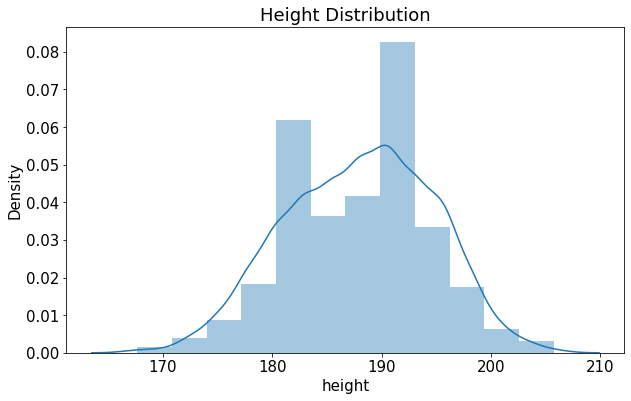

In [16]:
mpl.rc('font', size=15) 
plt.figure(figsize=(10, 6))

ax = sns.distplot(players['height'], bins=12)
ax.set_title('Height Distribution');

C:\Users\Ae\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


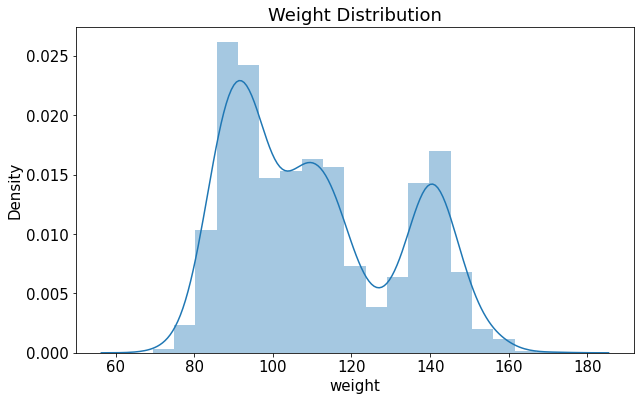

In [17]:
mpl.rc('font', size=15) 
plt.figure(figsize=(10, 6))

ax = sns.distplot(players['weight'])
ax.set_title('Weight Distribution');

In [18]:
top_players_colleage = players['collegeName'].value_counts()[:20].reset_index()
top_players_colleage.columns = ['collageName', 'numberOfPlayers']

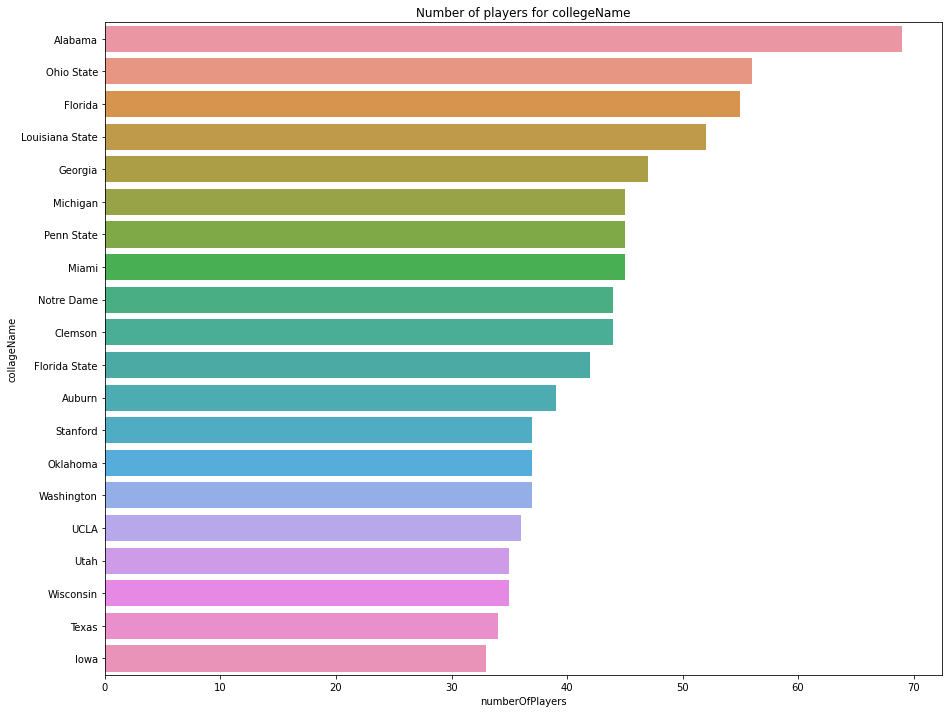

In [19]:
mpl.rc('font', size=10) 
plt.figure(figsize=(15, 12))

ax = sns.barplot(x='numberOfPlayers', y='collageName', data=top_players_colleage)
ax.set_title('Number of players for collegeName');

Create birth year feature

In [20]:
age = players["age"].value_counts().rename_axis('age').reset_index(name='count')

In [21]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Pie(labels=age['age'],
                             hoverinfo='label+percent',
                             values=age['count'], 
                             textposition='outside', 
                             rotation=90)])

fig.update_layout(title="Percentage of ages",
                  font=dict(family='Arial', size=12, color='#909090'),
                  legend=dict(x=0.9, y=0.5)
        )

fig.show()

<AxesSubplot:xlabel='age', ylabel='count'>

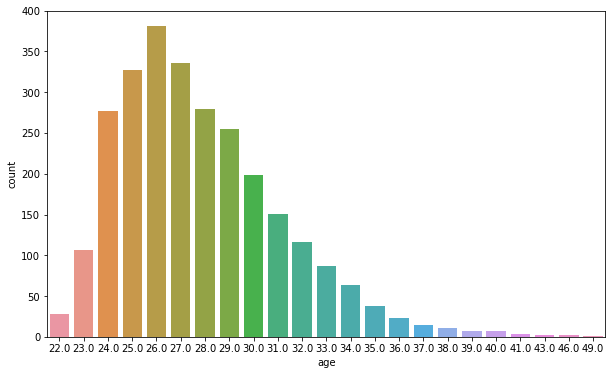

In [22]:
plt.figure(figsize=(10, 6))
sns.countplot(x="age",data=players)

Age 26 are the most common

# 3. Play Data
Play data: The plays.csv file contains play-level information from each game. The key variables are gameId and playId
gameId: Game identifier, unique (numeric)
playId: Play identifier, not unique across games (numeric)
playDescription: Description of play (text)
quarter: Game quarter (numeric)
down: Down (numeric)
yardsToGo: Distance needed for a first down (numeric)
possessionTeam: Team punting, placekicking or kicking off the ball (text)
specialTeamsPlayType: Formation of play: Extra Point, Field Goal, Kickoff or Punt (text)
specialTeamsPlayResult: Special Teams outcome of play dependent on play type: Blocked Kick Attempt, Blocked Punt, Downed, Fair Catch, Kick Attempt Good, Kick Attempt No Good, Kickoff Team Recovery, Muffed, Non-Special Teams Result, Out of Bounds, Return or Touchback (text)
kickerId: nflId of placekicker, punter or kickoff specialist on play (numeric)
returnerId: nflId(s) of returner(s) on play if there was a special teams return. Multiple returners on a play are separated by a ; (text)
kickBlockerId: nflId of blocker of kick on play if there was a blocked field goal or blocked punt (numeric)
yardlineSide: 3-letter team code corresponding to line-of-scrimmage (text)
yardlineNumber: Yard line at line-of-scrimmage (numeric)
gameClock: Time on clock of play (MM:SS)
penaltyCodes: NFL categorization of the penalties that occurred on the play. Multiple penalties on a play are separated by a ; (text)
penaltyJerseyNumber: Jersey number and team code of the player committing each penalty. Multiple penalties on a play are separated by a ; (text)
penaltyYards: yards gained by possessionTeam by penalty (numeric)
preSnapHomeScore: Home score prior to the play (numeric)
preSnapVisitorScore: Visiting team score prior to the play (numeric)
passResult: Scrimmage outcome of the play if specialTeamsPlayResult is "Non-Special Teams Result" (C: Complete pass, I: Incomplete pass, S: Quarterback sack, IN: Intercepted pass, R: Scramble, ' ': Designed Rush, text)
kickLength: Kick length in air of kickoff, field goal or punt (numeric)
kickReturnYardage: Yards gained by return team if there was a return on a kickoff or punt (numeric)
playResult: Net yards gained by the kicking team, including penalty yardage (numeric)
absoluteYardlineNumber: Location of ball downfield in tracking data coordinates (numeric)

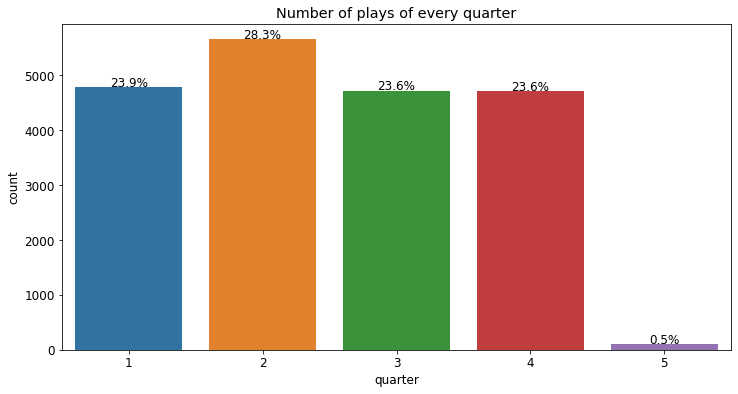

In [23]:
mpl.rc('font', size=12) 
plt.figure(figsize=(12, 6))

ax = sns.countplot(x='quarter', data=plays)
write_percent(ax, len(plays))
ax.set_title('Number of plays of every quarter');

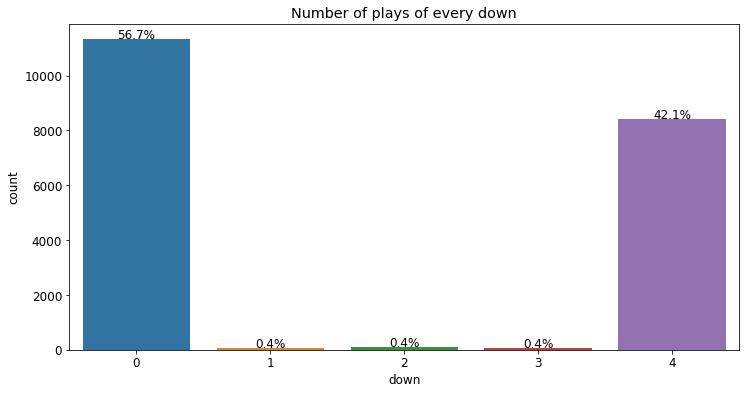

In [24]:
mpl.rc('font', size=12) 
plt.figure(figsize=(12, 6))

ax = sns.countplot(x='down', data=plays)
write_percent(ax, len(plays))
ax.set_title('Number of plays of every down');

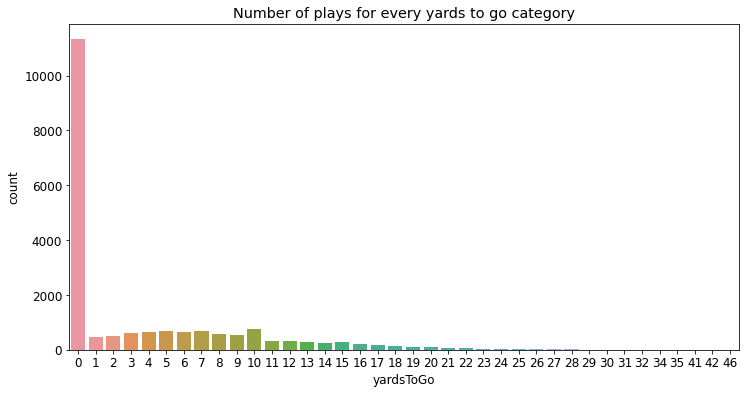

In [25]:
mpl.rc('font', size=12) 
plt.figure(figsize=(12, 6))

ax = sns.countplot(x='yardsToGo', data=plays)
ax.set_title('Number of plays for every yards to go category');

C:\Users\Ae\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



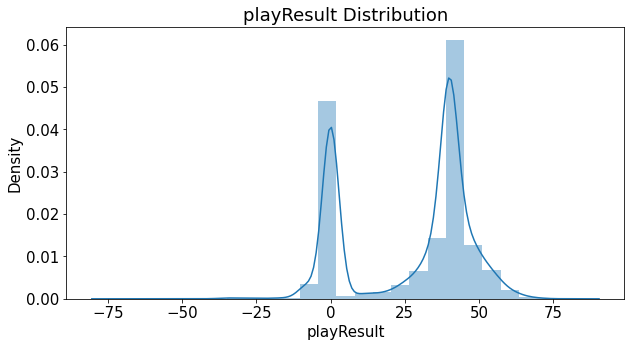

In [26]:
mpl.rc('font', size=15) 
plt.figure(figsize=(10, 5))

ax = sns.distplot(plays['playResult'], bins=25);
ax.set_title('playResult Distribution');

playResult: Net yards gained by the offense, including penalty yardage (numeric)

C:\Users\Ae\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



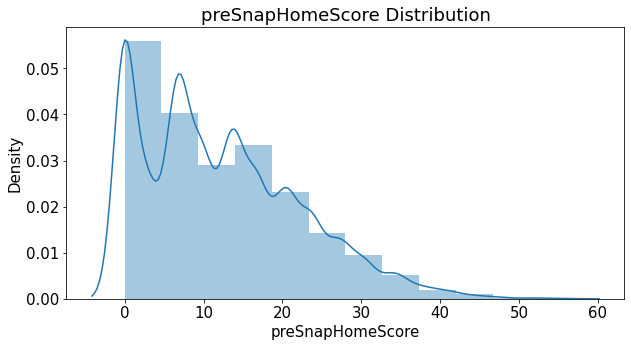

In [27]:
mpl.rc('font', size=15) 
plt.figure(figsize=(10, 5))

ax = sns.distplot(plays['preSnapHomeScore'], bins=12);
ax.set_title('preSnapHomeScore Distribution'); 

preSnapHomeScore: Home score prior to the play (numeric)

C:\Users\Ae\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



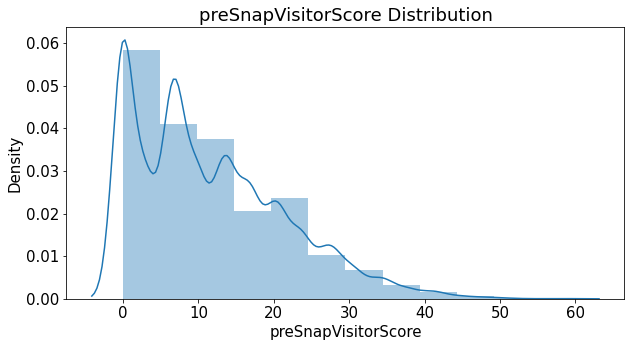

In [28]:
mpl.rc('font', size=15) 
plt.figure(figsize=(10, 5))

ax = sns.distplot(plays['preSnapVisitorScore'], bins=12);
ax.set_title('preSnapVisitorScore Distribution');

preSnapVisitorScore: Visiting team score prior to the play (numeric)

# 4. Tracking Data

In [29]:
tracking2018.head()

time      x      y     s     a   dis       o     dir  \
0  2018-12-30T21:25:32.200  41.32  29.45  4.36  1.33  0.43  130.42  128.44   
1  2018-12-30T21:25:32.300  41.68  29.17  4.59  1.24  0.45  128.59  127.81   
2  2018-12-30T21:25:32.400  42.05  28.88  4.74  0.99  0.47  124.47  128.15   
3  2018-12-30T21:25:32.500  42.43  28.59  4.87  0.71  0.48  126.02  127.35   
4  2018-12-30T21:25:32.600  42.84  28.31  4.96  0.79  0.50  131.71  124.75   

  event    nflId    displayName  jerseyNumber position  team  frameId  \
0  None  39470.0  Justin Tucker           9.0        K  home        1   
1  None  39470.0  Justin Tucker           9.0        K  home        2   
2  None  39470.0  Justin Tucker           9.0        K  home        3   
3  None  39470.0  Justin Tucker           9.0        K  home        4   
4  None  39470.0  Justin Tucker           9.0        K  home        5   

       gameId  playId playDirection  
0  2018123000      36         right  
1  2018123000      36         right  
2  2018123000      36         right  
3  2018123000      36         right  
4  2018123000      36         right

2018123000 and playId == 36

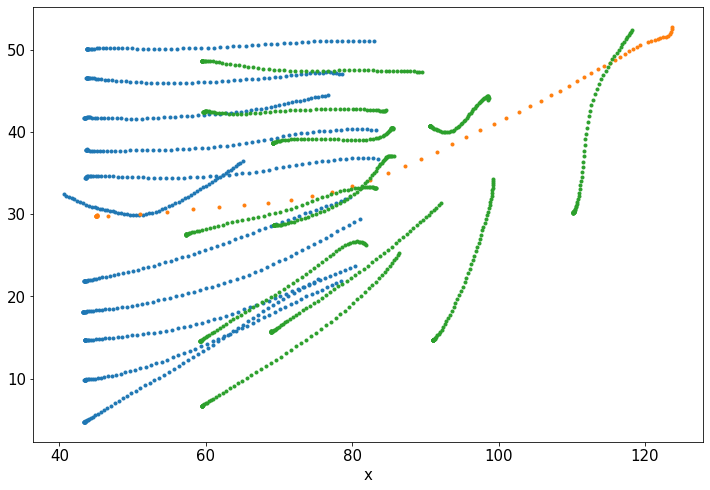

In [30]:
fig, ax = plt.subplots(figsize=(12, 8))
tracking2018.query('gameId == 2018091001 and playId == 4033').groupby('team') \
    .plot(x='x', y='y', ax=ax, style='.')
plt.legend().remove();

gameId == 2018091609 and position == "CB"

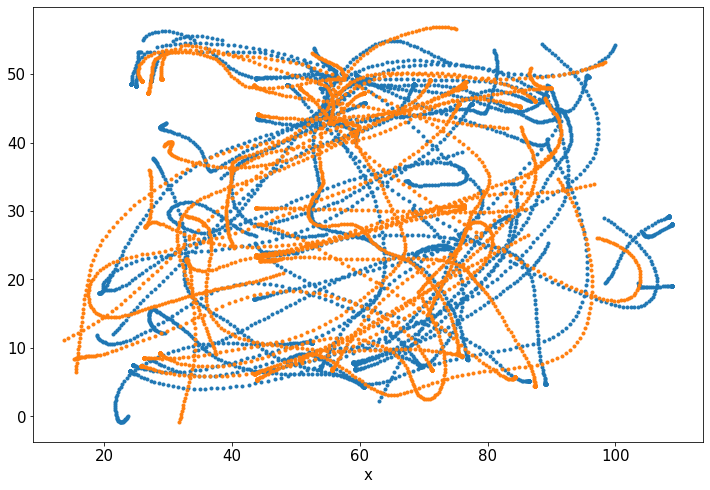

In [31]:
fig, ax = plt.subplots(figsize=(12, 8))
tracking2018.query('gameId == 2018091609 and position == "CB"').groupby('team') \
    .plot(x='x', y='y', ax=ax, style='.')
plt.legend().remove();

gameId == 2018091609 and position == "LB"

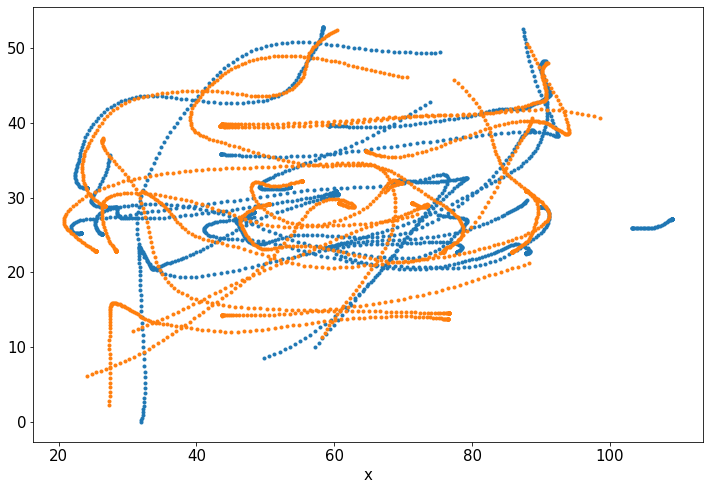

In [32]:
fig, ax = plt.subplots(figsize=(12, 8))
tracking2018.query('gameId == 2018091609 and position == "LB"').groupby('team') \
    .plot(x='x', y='y', ax=ax, style='.')
plt.legend().remove();

gameId == 2018091609 and position == "RB"

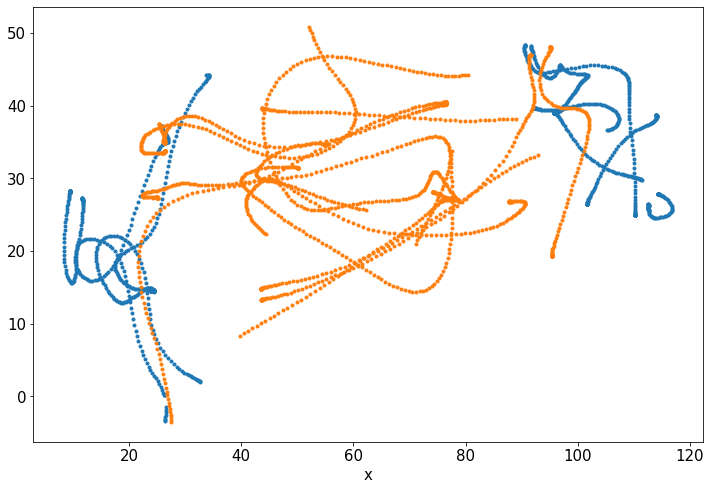

In [33]:
fig, ax = plt.subplots(figsize=(12, 8))
tracking2018.query('gameId == 2018091609 and position == "RB"').groupby('team') \
    .plot(x='x', y='y', ax=ax, style='.')
plt.legend().remove();

# Function to create football field

In [34]:
import matplotlib.patches as patches
from matplotlib.patches import Arc
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

# Change size of the figure
plt.rcParams['figure.figsize'] = [12, 8]
def drawPitch(width, height, color="w"):
    fig = plt.figure()
    ax = plt.axes(xlim=(-10, width + 30), ylim=(-15, height + 5))
    plt.axis('off')

    # Grass around pitch
    rect = patches.Rectangle((-10, -5), width + 40, height + 10, linewidth=1, facecolor='#3f995b', capstyle='round')
    ax.add_patch(rect)
    ###################

    # Pitch boundaries
    rect = plt.Rectangle((0, 0), width + 20, height, ec=color, fc="None", lw=2)
    ax.add_patch(rect)
    ###################

    # vertical lines - every 5 yards
    for i in range(21):
        plt.plot([10 + 5 * i, 10 + 5 * i], [0, height], c="w", lw=2)
    ###################
        
    # distance markers - every 10 yards
    for yards in range(10, width, 10):
        yards_text = yards if yards <= width / 2 else width - yards
        # top markers
        plt.text(10 + yards - 2, height - 7.5, yards_text, size=15, c="w", weight="bold")
        # botoom markers
        plt.text(10 + yards - 2, 7.5, yards_text, size=15, c="w", weight="bold", rotation=180)
    ###################

    # yards markers - every yard
    # bottom markers
    for x in range(20):
        for j in range(1, 5):
            plt.plot([10 + x * 5 + j, 10 + x * 5 + j], [1, 3], color="w", lw=2)

    # top markers
    for x in range(20):
        for j in range(1, 5):
            plt.plot([10 + x * 5 + j, 10 + x * 5 + j], [height - 1, height - 3], color="w", lw=2)

    # middle bottom markers
    y = (height - 18.5) / 2
    for x in range(20):
        for j in range(1, 5):
            plt.plot([10 + x * 5 + j, 10 + x * 5 + j], [y, y + 2], color="w", lw=2)

    # middle top markers
    for x in range(20):
        for j in range(1, 5):
            plt.plot([10 + x * 5 + j, 10 + x * 5 + j], [height - y, height - y - 2], color="w", lw=2)
    ###################

    # draw home end zone
    plt.text(2.5, (height - 15) / 2, "HOME", size=30, c="w", weight="bold", rotation=90)
    rect = plt.Rectangle((0, 0), 10, height, ec=color, fc="#0064dc", lw=2)
    ax.add_patch(rect)

    # draw away end zone    
    plt.text(111, (height - 15) / 2, "AWAY", size=30, c="w", weight="bold", rotation=-90)
    rect = plt.Rectangle((width + 10, 0), 10, height, ec=color, fc="#c80014", lw=2)
    ax.add_patch(rect)
    ###################
    
    # draw extra spot point
    # left
    y = (height - 3) / 2
    plt.plot([10 + 2, 10 + 2], [y, y + 3], c="w", lw=2)
    
    # right
    plt.plot([width + 10 - 2, width + 10 - 2], [y, y + 3], c="w", lw=2)
    ###################
    
    # draw goalpost
    goal_width = 6 # yards
    y = (height - goal_width) / 2
    # left
    plt.plot([0, 0], [y, y + goal_width], "-", c="y", lw=10, ms=20)
    # right
    plt.plot([width + 20, width + 20], [y, y + goal_width], "-", c="y", lw=10, ms=20)
    
    return fig, ax

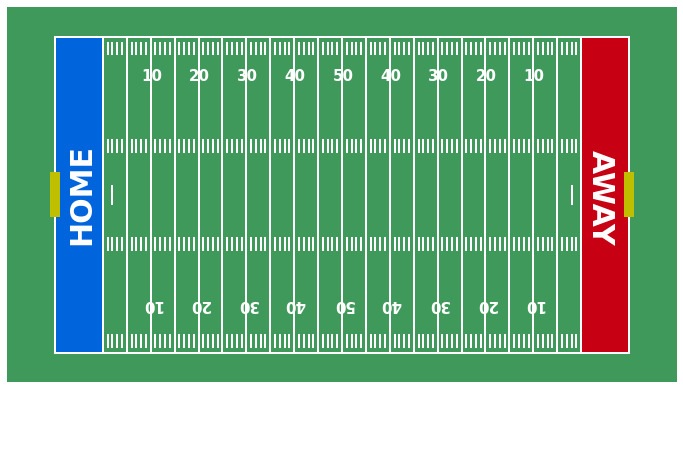

In [35]:
 fig, ax = drawPitch(100, 53.3)

Function to create animation

In [36]:
games_ids = {}
games_tracking2018 = tracking2018.groupby(by=["gameId"])
for game, data in games_tracking2018:
    games_ids[game] = list(set(data.playId.tolist()))

In [37]:
def extract_one_game(game_id, play_id, df):
    game = df[(df.gameId == game_id) & (df.playId == play_id)]
    home = {}
    away = {}
    balls = []
    
    players = game.sort_values(['frameId'], ascending=True).groupby('nflId')
    for id, dx in players:
        jerseyNumber = int(dx.jerseyNumber.iloc[0])
        if dx.team.iloc[0] == "home":
            home[jerseyNumber] = list(zip(dx.x.tolist(), dx.y.tolist()))
        elif dx.team.iloc[0] == "away":
            away[jerseyNumber] = list(zip(dx.x.tolist(), dx.y.tolist()))


    ball_df = game.sort_values(['frameId'], ascending=True) 
    ball_df = ball_df[ball_df.team == "football"]
    balls = list(zip(ball_df.x.tolist(), ball_df.y.tolist()))
    return home, away, balls

In [38]:
from matplotlib import animation
from IPython.display import HTML
def animate_one_play(game_id, play_id, df):
    fig, ax = drawPitch(100, 53.3)
    
    home, away, balls = extract_one_game(game_id, play_id, df)

    team_left, = ax.plot([], [], 'o', markersize=20, markerfacecolor="r", markeredgewidth=2, markeredgecolor="white", zorder=7)
    team_right, = ax.plot([], [], 'o', markersize=20, markerfacecolor="b", markeredgewidth=2, markeredgecolor="white", zorder=7)
    ball, = ax.plot([], [], 'o', markersize=10, markerfacecolor="black", markeredgewidth=2, markeredgecolor="white", zorder=7)
    drawings = [team_left, team_right, ball]

    def init():
        team_left.set_data([], [])
        team_right.set_data([], [])
        ball.set_data([], [])
        return drawings

    def draw_teams(i):
        X = []
        Y = []
        for k, v in home.items():
            x, y = v[i]
            X.append(x)
            Y.append(y)
        team_left.set_data(X, Y)
        
        X = []
        Y = []
        for k, v in away.items():
            x, y = v[i]
            X.append(x)
            Y.append(y)
        team_right.set_data(X, Y)

    def animate(i):
        draw_teams(i)
        
        x, y = balls[i]
        ball.set_data([x, y])
        return drawings
    
    # !May take a while!
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(balls), interval=100, blit=True)

    return HTML(anim.to_html5_video())

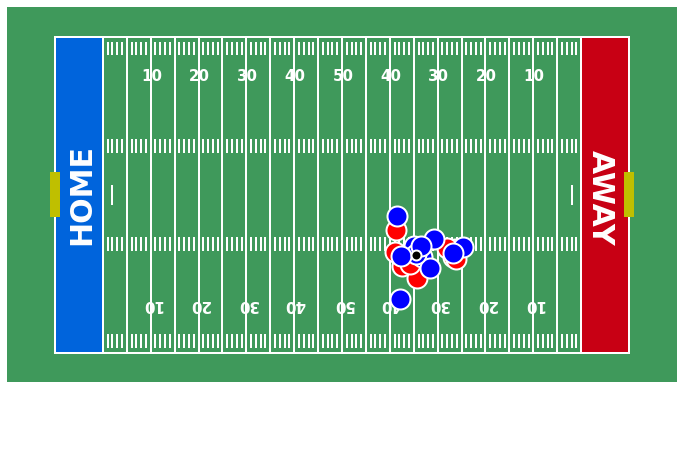

In [39]:
animate_one_play(2018123000, 36, tracking2018)

<AxesSubplot:title={'center':'Total special-teams plays by type'}>

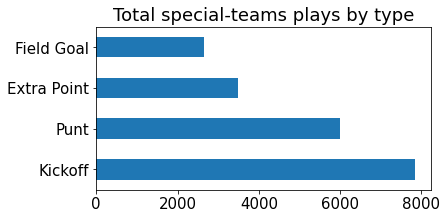

In [40]:
plays['specialTeamsPlayType'].value_counts().plot.barh(figsize=(6,3),
                                                           title="Total special-teams plays by type")

In [41]:
# how many Field Goal were played from the data source?
import plotly.express as px

play_data_aggr = plays.groupby('specialTeamsPlayType').nunique().reset_index()[['specialTeamsPlayType','playId']]
fig = px.bar(play_data_aggr, 
             x='specialTeamsPlayType', 
             y='playId',
             labels={'specialTeamsPlayType':'Type of Special team plays',
                   'playId':'Number of plays'}
            )
fig.update_layout(title_text='Number of special team plays per type<br><sup>Kickoff has the highest number of play in all four special team types</sup>')

fig.show()

In [42]:
Plays_FG_Kickatt = plays.loc[(plays['specialTeamsPlayType'] == 'Field Goal') & ((plays['specialTeamsResult'] == 'Kick Attempt Good') | (plays['specialTeamsResult'] == 'Kick Attempt No Good' ))]

In [43]:
Plays_FG_Kickatt

gameId  playId                                    playDescription  \
2      2018090600     658  (5:03) M.Bryant 21 yard field goal is GOOD, Ce...   
6      2018090600    1368  (6:12) J.Elliott 26 yard field goal is GOOD, C...   
8      2018090600    1587  (2:13) M.Bryant 52 yard field goal is GOOD, Ce...   
33     2018090900    1226  (13:18) (Field Goal formation) J.Tucker 41 yar...   
36     2018090900    1613  (8:48) (Field Goal formation) S.Hauschka 52 ya...   
...           ...     ...                                                ...   
19952  2021010315     811  (2:13) J.Myers 36 yard field goal is GOOD, Cen...   
19955  2021010315    1243  (9:31) J.Myers 30 yard field goal is GOOD, Cen...   
19959  2021010315    1784  (:29) T.Vizcaino 36 yard field goal is GOOD, C...   
19962  2021010315    2121  (9:36) T.Vizcaino 47 yard field goal is GOOD, ...   
19965  2021010315    2366  (6:23) T.Vizcaino 33 yard field goal is GOOD, ...   

       quarter  down  yardsToGo possessionTeam specialTeamsPlayType  \
2            1     4          3            ATL           Field Goal   
6            2     4          8            PHI           Field Goal   
8            2     4         17            ATL           Field Goal   
33           2     4         13            BAL           Field Goal   
36           2     4          9            BUF           Field Goal   
...        ...   ...        ...            ...                  ...   
19952        1     4         10            SEA           Field Goal   
19955        2     4          3            SEA           Field Goal   
19959        2     4          6             SF           Field Goal   
19962        3     4          8             SF           Field Goal   
19965        3     4         15             SF           Field Goal   

         specialTeamsResult  kickerId  ... penaltyCodes  penaltyJerseyNumbers  \
2         Kick Attempt Good   27091.0  ...          NaN                   NaN   
6         Kick Attempt Good   44966.0  ...          NaN                   NaN   
8         Kick Attempt Good   27091.0  ...          NaN                   NaN   
33        Kick Attempt Good   39470.0  ...          NaN                   NaN   
36     Kick Attempt No Good   33469.0  ...          NaN                   NaN   
...                     ...       ...  ...          ...                   ...   
19952     Kick Attempt Good   41175.0  ...          NaN                   NaN   
19955     Kick Attempt Good   41175.0  ...          NaN                   NaN   
19959     Kick Attempt Good   47590.0  ...          NaN                   NaN   
19962     Kick Attempt Good   47590.0  ...          NaN                   NaN   
19965     Kick Attempt Good   47590.0  ...          NaN                   NaN   

      penaltyYards  preSnapHomeScore preSnapVisitorScore passResult  \
2              NaN                 0                   0        NaN   
6              NaN                 0                   3        NaN   
8              NaN                 3                   3        NaN   
33             NaN                14                   0        NaN   
36             NaN                17                   0        NaN   
...            ...               ...                 ...        ...   
19952          NaN                 0                   0        NaN   
19955          NaN                 0                   3        NaN   
19959          NaN                 0                   6        NaN   
19962          NaN                 3                   6        NaN   
19965          NaN                 6                   6        NaN   

      kickLength  kickReturnYardage  playResult  absoluteYardlineNumber  
2           21.0                NaN           0                      13  
6           26.0                NaN           0                      18  
8           52.0                NaN           0                      76  
33          41.0                NaN           0                      33  
3

In [44]:
players

nflId  height  weight  birthDate          collegeName Position  \
0     42901  185.42   94.35 1992-07-25        James Madison       SS   
1     43501  182.88   99.79 1994-08-11     Central Michigan       FS   
2     43534  182.88   92.99 1993-06-02             Illinois       SS   
3     43535  185.42  106.59 1992-12-22               Temple      MLB   
4     44174  185.42  107.05 1993-02-22           Texas Tech      ILB   
...     ...     ...     ...        ...                  ...      ...   
2727  33216  190.50  145.15 1986-06-16      Central Florida        G   
2728  33184  190.50  120.20 1985-05-02  Winston-Salem State       DE   
2729  45651  175.26   89.81 1993-06-16                 Iowa       WR   
2730  41284  185.42  104.33 1992-10-20                  LSU       RB   
2731  42849  177.80   92.99 1992-12-14           Texas Tech       WR   

            displayName   age  
0          Dean Marlowe  29.0  
1         Kavon Frazier  27.0  
2     Clayton Fejedelem  28.0  
3      Tyler Matakevich  29.0  
4          Sam Eguavoen  28.0  
...                 ...   ...  
2727        Josh Sitton  35.0  
2728      William Hayes  36.0  
2729     Riley McCarron  28.0  
2730        Jeremy Hill  29.0  
2731    Bradley Marquez  29.0  

[2732 rows x 8 columns]

In [45]:
player_stat=Plays_FG_Kickatt.groupby(['kickerId','specialTeamsResult']).size()
player_stat = Plays_FG_Kickatt.groupby(['kickerId','specialTeamsResult'], as_index = False).size()
kicklenght=(Plays_FG_Kickatt.groupby('kickerId')['kickLength'].mean()).to_frame()
kicklenght=kicklenght.reset_index()
kicklenght.rename(columns = {'kickerId':'nflId'}, inplace = True)

In [46]:
kicklenght

nflId  kickLength
0   21213.0   37.553192
1   23860.0   36.750000
2   25326.0   40.291668
3   27091.0   41.352940
4   29874.0   34.526318
5   30403.0   36.948051
6   30932.0   38.793652
7   31446.0   38.000000
8   32371.0   36.804878
9   32386.0   39.478874
10  33469.0   39.777779
11  34707.0   35.783333
12  35102.0   39.911110
13  38134.0   37.098591
14  38220.0   37.555557
15  38691.0   39.116882
16  38701.0   39.445652
17  38815.0   20.000000
18  38851.0   42.599998
19  39470.0   37.967392
20  40114.0   36.700001
21  40125.0   39.070587
22  40276.0   40.780487
23  40775.0   38.516666
24  41112.0   51.000000
25  41175.0   39.362499
26  41688.0   37.452831
27  41736.0   36.157894
28  41953.0   35.967743
29  41991.0   37.480000
30  42112.0   40.750000
31  42663.0   41.714287
32  43068.0   37.771931
33  43689.0   37.505882
34  43846.0   38.265957
35  43902.0   31.500000
36  43937.0   36.211540
37  44240.0   39.315788
38  44966.0   38.242424
39  45037.0   38.258064
40  45046.0   35.916668
41  45576.0   36.789474
42  46236.0   35.883118
43  46298.0   39.132530
44  46342.0   38.491802
45  46426.0   34.708332
46  46455.0   45.000000
47  46634.0   37.578949
48  46663.0   40.181820
49  47423.0   23.000000
50  47590.0   38.666668
51  47928.0   39.860466
52  47953.0   38.911766
53  48329.0   39.500000
54  48337.0   40.584908
55  48488.0   39.136364
56  52596.0   40.107143
57  52656.0   33.888889
58  52751.0   35.694443

In [47]:
player_stat.set_index('kickerId')
player_stat
player_stat1 = player_stat.pivot_table('size', ['kickerId'], 'specialTeamsResult')
player_stat1=player_stat1.reset_index()
player_stat1.rename(columns = {'kickerId':'nflId'}, inplace = True)
player_stat1

specialTeamsResult    nflId  Kick Attempt Good  Kick Attempt No Good
0                   21213.0               38.0                   9.0
1                   23860.0                5.0                   3.0
2                   25326.0               20.0                   4.0
3                   27091.0               28.0                   6.0
4                   29874.0               17.0                   2.0
5                   30403.0               66.0                  11.0
6                   30932.0               51.0                  12.0
7                   31446.0               65.0                  13.0
8                   32371.0               38.0                   3.0
9                   32386.0               63.0                   8.0
10                  33469.0               43.0                  11.0
11                  34707.0               52.0                   8.0
12                  35102.0               42.0                   3.0
13                  38134.0               59.0                  12.0
14                  38220.0               16.0                   2.0
15                  38691.0               66.0                  11.0
16                  38701.0               76.0                  16.0
17                  38815.0                1.0                   NaN
18                  38851.0                5.0                   NaN
19                  39470.0               87.0                   5.0
20                  40114.0                7.0                   3.0
21                  40125.0               73.0                  12.0
22                  40276.0               72.0                  10.0
23                  40775.0               47.0                  13.0
24                  41112.0                NaN                   1.0
25                  41175.0               73.0                   7.0
26                  41688.0               44.0                   9.0
27                  41736.0               15.0                   4.0
28                  41953.0               55.0                   7.0
29                  41991.0               41.0                   9.0
30                  42112.0                8.0                   4.0
31                  42663.0                5.0                   2.0
32                  43068.0               54.0                   3.0
33                  43689.0               77.0                   8.0
34                  43846.0               81.0                  13.0
35                  43902.0                1.0                   1.0
36                  43937.0               45.0                   7.0
37                  44240.0               30.0                   8.0
38                  44966.0               54.0                  12.0
39                  45037.0               50.0                  12.0
40                  45046.0               77.0                   7.0
41                  45576.0               52.0                   5.0
42                  46236.0               64.0                  13.0
43                  46298.0               71.0                  12.0
44                  46342.0               49.0                  12.0
45                  46426.0               20.0                   4.0
46                  46455.0                NaN                   1.0
47                  46634.0               16.0                   3.0
48                  46663.0                8.0                   3.0
49                  47423.0                1.0                   NaN
50                  47590.0                3.0                   NaN
51                  47928.0               35.0                   8.0
52                  47953.0               27.0                   7.0
53                  48329.0                4.0                   NaN
54                  48337.0               42.0                  11.0
55                  48488.0               18.0                   4.0
56                  52596.0               22.0                   6.

In [48]:
players_stat = pd.merge(players, 
                      player_stat1, 
                      on ='nflId', 
                      how ='inner')
players_stat = pd.merge(players_stat, 
                      kicklenght, 
                      on ='nflId', 
                      how ='inner')

In [49]:
players_stat['Kick Attempt Good'] = players_stat['Kick Attempt Good'].fillna(0)
players_stat['Kick Attempt No Good'] = players_stat['Kick Attempt No Good'].fillna(0)
players_stat['Total Attemp'] = players_stat['Kick Attempt Good'] + players_stat['Kick Attempt No Good']

In [50]:
players_stat['FG %'] = players_stat['Kick Attempt Good']/players_stat['Total Attemp']*100
players_stat

nflId  height  weight  birthDate           collegeName Position  \
0   46298  180.34   84.37 1995-11-16            New Mexico        K   
1   52596  177.80   83.91 1997-02-14      Georgia Southern        K   
2   43689  180.34   83.46 1994-07-07         Georgia State        K   
3   48337  180.34   96.62 1996-04-10         Virginia Tech        K   
4   32386  185.42   93.89 1984-09-03              Colorado        K   
5   41991  172.72   72.57 1991-11-18                Tulane        K   
6   47953  175.26   97.07 1996-11-15              Oklahoma        K   
7   39470  185.42   83.01 1989-11-21                 Texas        K   
8   41688  182.88   86.18 1992-02-19                Auburn        K   
9   48329  182.88   81.19 1996-03-22       Central Florida        K   
10  31446  177.80   91.17 1984-08-10       Central Florida        K   
11  38134  182.88   86.18 1988-01-26        Oklahoma State        K   
12  42663  187.96   92.99 1993-04-06    Alabama-Birmingham        P   
13  45046  193.04   92.99 1995-07-14          Georgia Tech        K   
14  46342  177.80   83.01 1995-07-28                 Miami        K   
15  48488  180.34   84.82 1996-04-09              Illinois        K   
16  32371  185.42  100.70 1984-11-05               Arizona        K   
17  38701  182.88   86.64 1987-12-27      Missouri Western        K   
18  35102  187.96   91.63 1987-04-09         Florida State        K   
19  40125  187.96   92.08 1990-10-01         Florida State        K   
20  44966  175.26   75.75 1995-01-21               Memphis        K   
21  45576  177.80   88.45 1994-08-03      Georgia Southern        K   
22  34707  187.96   98.88 1986-09-19        South Carolina        K   
23  40276  190.50   91.17 1991-07-25                Temple        K   
24  46236  195.58   97.52 1995-01-23                Auburn        K   
25  52656  172.72   92.99 1997-09-19             Miami, O.        K   
26  43846  182.88   83.01 1994-01-29                  UCLA        K   
27  52751  185.42   86.64 1997-01-29               Georgia        K   
28  43937  190.50  100.24 1994-12-30       Southern Oregon        K   
29  47928  182.88  105.23 1994-03-15                  Utah        K   
30  29874  177.80   86.18 1982-03-02            Ohio State        K   
31  38815  195.58  109.32 1990-02-08          Oregon State        P   
32  41175  177.80   86.18 1991-05-12                Marist        K   
33  47590  187.96   92.99 1996-07-31            Washington        K   
34  30403  182.88   86.18 1982-12-06            Penn State        K   
35  44240  185.42   87.09 1992-12-14            Penn State        K   
36  30932  185.42   97.52 1984-01-28               Memphis        K   
37  41112  180.34   72.57        NaT                   NaN        K   
38  41953  187.96   83.91 1991-03-16                  Rice        K   
39  42112  180.34   88.45 1990-11-01    West Texas A&amp;M        K   
40  38691  175.26   95.25 1989-12-16         Texas A&amp;M        K   
41  45037  182.88   91.63 1995-05-07         Arizona State        K   
42  38220  180.34   89.36 1987-09-02                  UCLA        K   
43  43068  182.88   97.52 1990-11-19         Texas A&amp;M        K   
44  43902  177.80   91.63 1992-12-07            Louisville        K   
45  33469  193.04   95.25 1985-06-29  North Carolina State        K   
46  47423  182.88   77.11 1994-12-12        South Carolina        K   
47  46634  182.88   95.25 1994-08-04      Florida Atlantic        K   
48  46426  180.34   80.74 1995-09-13               Florida        K   
49  40775  185.42   83.91 1989-11-21              Nebraska        K   
50  21213  182.88   96.16 1972-12-28    South Dakota State        K   
51  27091  175.26   92.08 1975-05-29                Baylor        K   
52  46455  190.50   95.25 1994-03-16              Marshall        K   
53  41736  190.50   90.72 1991-02-26               Clemson        K   
54  46663  177.80   74.84 1994-09-08          Kansas State        K   
55  25326  185.42  117.03 19

In [51]:
Plays_FG_Kickatt['kickLength'].describe()

count    2604.000000
mean       38.157066
std        10.084785
min        19.000000
25%        30.000000
50%        38.000000
75%        46.000000
max        67.000000
Name: kickLength, dtype: float64

In [52]:
players_stat.sort_values(["Kick Attempt Good","FG %"],ascending=False, inplace = True)
players_stat

nflId  height  weight  birthDate           collegeName Position  \
7   39470  185.42   83.01 1989-11-21                 Texas        K   
26  43846  182.88   83.01 1994-01-29                  UCLA        K   
13  45046  193.04   92.99 1995-07-14          Georgia Tech        K   
2   43689  180.34   83.46 1994-07-07         Georgia State        K   
17  38701  182.88   86.64 1987-12-27      Missouri Western        K   
32  41175  177.80   86.18 1991-05-12                Marist        K   
19  40125  187.96   92.08 1990-10-01         Florida State        K   
23  40276  190.50   91.17 1991-07-25                Temple        K   
0   46298  180.34   84.37 1995-11-16            New Mexico        K   
34  30403  182.88   86.18 1982-12-06            Penn State        K   
40  38691  175.26   95.25 1989-12-16         Texas A&amp;M        K   
10  31446  177.80   91.17 1984-08-10       Central Florida        K   
24  46236  195.58   97.52 1995-01-23                Auburn        K   
4   32386  185.42   93.89 1984-09-03              Colorado        K   
11  38134  182.88   86.18 1988-01-26        Oklahoma State        K   
38  41953  187.96   83.91 1991-03-16                  Rice        K   
43  43068  182.88   97.52 1990-11-19         Texas A&amp;M        K   
20  44966  175.26   75.75 1995-01-21               Memphis        K   
21  45576  177.80   88.45 1994-08-03      Georgia Southern        K   
22  34707  187.96   98.88 1986-09-19        South Carolina        K   
36  30932  185.42   97.52 1984-01-28               Memphis        K   
41  45037  182.88   91.63 1995-05-07         Arizona State        K   
14  46342  177.80   83.01 1995-07-28                 Miami        K   
49  40775  185.42   83.91 1989-11-21              Nebraska        K   
28  43937  190.50  100.24 1994-12-30       Southern Oregon        K   
8   41688  182.88   86.18 1992-02-19                Auburn        K   
45  33469  193.04   95.25 1985-06-29  North Carolina State        K   
18  35102  187.96   91.63 1987-04-09         Florida State        K   
3   48337  180.34   96.62 1996-04-10         Virginia Tech        K   
5   41991  172.72   72.57 1991-11-18                Tulane        K   
16  32371  185.42  100.70 1984-11-05               Arizona        K   
50  21213  182.88   96.16 1972-12-28    South Dakota State        K   
29  47928  182.88  105.23 1994-03-15                  Utah        K   
27  52751  185.42   86.64 1997-01-29               Georgia        K   
35  44240  185.42   87.09 1992-12-14            Penn State        K   
51  27091  175.26   92.08 1975-05-29                Baylor        K   
6   47953  175.26   97.07 1996-11-15              Oklahoma        K   
1   52596  177.80   83.91 1997-02-14      Georgia Southern        K   
48  46426  180.34   80.74 1995-09-13               Florida        K   
55  25326  185.42  117.03 1978-03-02         Florida State        K   
15  48488  180.34   84.82 1996-04-09              Illinois        K   
30  29874  177.80   86.18 1982-03-02            Ohio State        K   
42  38220  180.34   89.36 1987-09-02                  UCLA        K   
47  46634  182.88   95.25 1994-08-04      Florida Atlantic        K   
53  41736  190.50   90.72 1991-02-26               Clemson        K   
25  52656  172.72   92.99 1997-09-19             Miami, O.        K   
54  46663  177.80   74.84 1994-09-08          Kansas State        K   
39  42112  180.34   88.45 1990-11-01    West Texas A&amp;M        K   
58  40114  175.26   87.09 1989-08-09               Florida        K   
57  38851  177.80   82.55 1990-07-16            California        K   
12  42663  187.96   92.99 1993-04-06    Alabama-Birmingham        P   
56  23860  180.34   90.72 1975-01-23                 Texas        K   
9   48329  182.88   81.19 1996-03-22       Central Florida        K   
33  47590  187.96   92.99 1996-07-31            Washington        K   
31  38815  195.58  109.32 1990-02-08          Oregon State        P   
46  47423  182.88   77.11 19

In [53]:
# select plays which are FG
FG_play = plays.loc[plays["specialTeamsPlayType"] == "Field Goal"]

In [54]:
# nr of specialTeamsResult of kickoff
FG_play_result = FG_play.groupby(['specialTeamsResult']).nunique().reset_index()[['specialTeamsResult','playId']]

fig = px.bar(FG_play_result, 
             x='specialTeamsResult', 
             y='playId',
             labels={'specialTeamsResult':'Result of FG',
                   'playId':'Number of plays'}
            )
fig.update_layout(title_text='Number of plays per FG result')

fig.show()

In [55]:
kickLength_aggr = FG_play.groupby(['kickLength']).nunique().reset_index()[['kickLength','playId']]

In [56]:
fig = px.bar(kickLength_aggr, 
             x='kickLength', 
             y='playId',
             labels={'kickLength':'Kick length',
                   'playId':'Number of FG'}
            )
fig.update_layout(title_text='Number of FG per kick length')

fig.show()

from the figure above we can see that most of the lenght fo FG is around 0-65 yard

In [57]:
from scipy.stats import norm

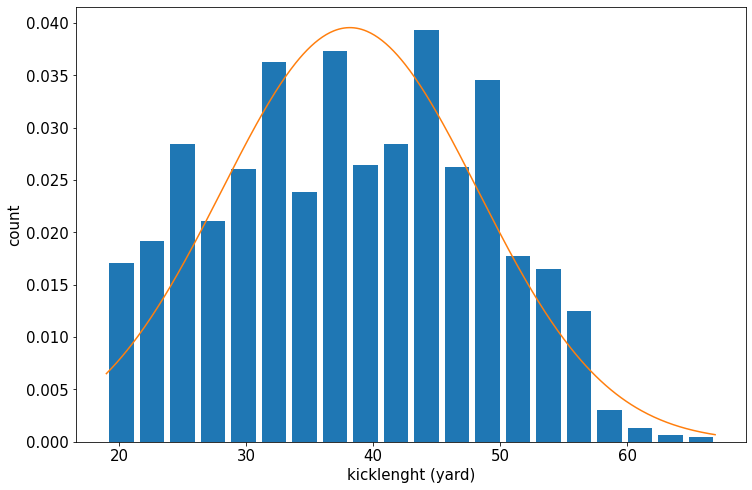

In [58]:
import matplotlib.pyplot as plt
plt.hist(Plays_FG_Kickatt.kickLength, bins=20,rwidth=0.8,density=True)
plt.xlabel('kicklenght (yard)')
plt.ylabel('count')
rng=np.arange(Plays_FG_Kickatt.kickLength.min(),Plays_FG_Kickatt.kickLength.max(),0.1)
plt.plot(rng,norm.pdf(rng,Plays_FG_Kickatt.kickLength.mean(),Plays_FG_Kickatt.kickLength.std()))

<AxesSubplot:xlabel='displayName'>

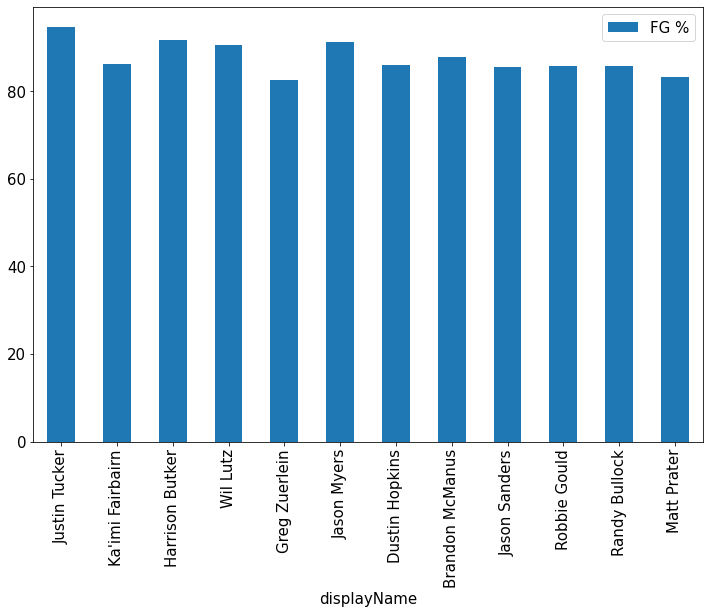

In [59]:
players_stat.head(12).plot.bar(x='displayName', y='FG %')

<AxesSubplot:xlabel='displayName'>

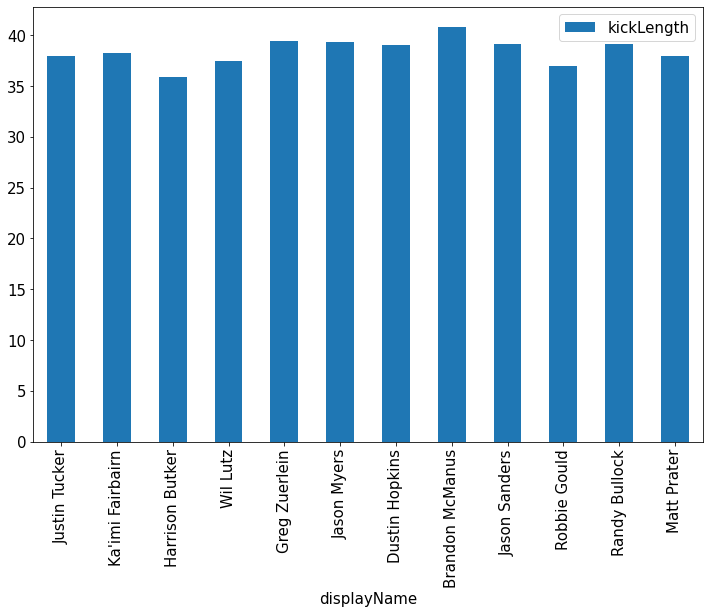

In [60]:
players_stat.head(12).plot.bar(x='displayName', y='kickLength')

<AxesSubplot:xlabel='displayName'>

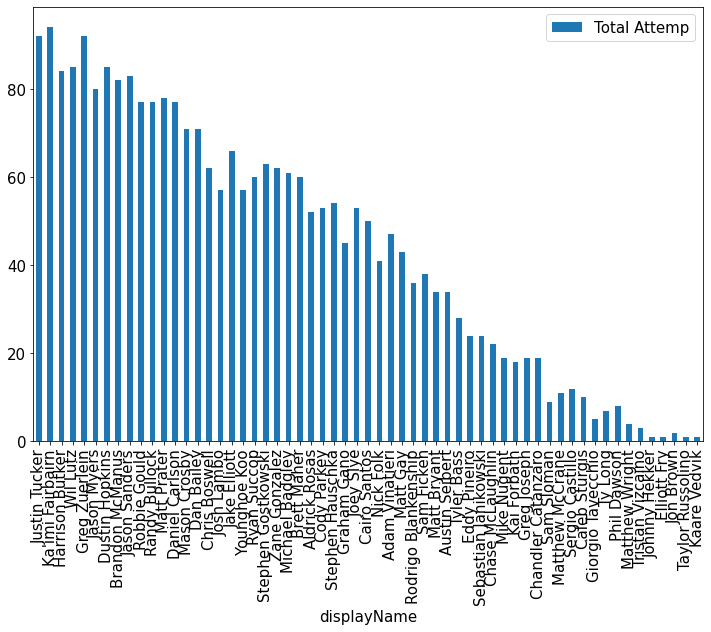

In [61]:
players_stat.head(100).plot.bar(x='displayName', y='Total Attemp')

In [62]:
players_stat.corr()

nflId    height    weight       age  \
nflId                 1.000000 -0.075119 -0.301178 -0.974449   
height               -0.075119  1.000000  0.443062  0.003047   
weight               -0.301178  0.443062  1.000000  0.297499   
age                  -0.974449  0.003047  0.297499  1.000000   
Kick Attempt Good    -0.122120  0.136266 -0.013787  0.046420   
Kick Attempt No Good -0.121155  0.038173 -0.024495  0.071647   
kickLength           -0.047409 -0.159215 -0.161963  0.056687   
Total Attemp         -0.125295  0.125441 -0.015747  0.051481   
FG %                 -0.026048  0.045782  0.125368 -0.011839   

                      Kick Attempt Good  Kick Attempt No Good  kickLength  \
nflId                         -0.122120             -0.121155   -0.047409   
height                         0.136266              0.038173   -0.159215   
weight                        -0.013787             -0.024495   -0.161963   
age                            0.046420              0.071647    0.056687   
Kick Attempt Good              1.000000              0.788507    0.088884   
Kick Attempt No Good           0.788507              1.000000    0.161467   
kickLength                     0.088884              0.161467    1.000000   
Total Attemp                   0.995844              0.841245    0.102047   
FG %                           0.339829              0.126398   -0.484759   

                      Total Attemp      FG %  
nflId                    -0.125295 -0.026048  
height                    0.125441  0.045782  
weight                   -0.015747  0.125368  
age                       0.051481 -0.011839  
Kick Attempt Good         0.995844  0.339829  
Kick Attempt No Good      0.841245  0.126398  
kickLength                0.102047 -0.484759  
Total Attemp              1.000000  0.317454  
FG %                      0.317454  1.000000

In [63]:
FG=players_stat[("Kick Attempt Good")].sum()/players_stat[("Total Attemp")].sum()
FG*100

85.17665130568356

In [64]:
lambda_func = lambda Plays_FG_Kickatt: pd.Series({'KickLength<20': sum(Plays_FG_Kickatt.kickLength < 20)})
kicklength_interval=Plays_FG_Kickatt.groupby('kickerId').apply(lambda_func)
lambda_func = lambda Plays_FG_Kickatt: pd.Series({'KickLength<20': sum((Plays_FG_Kickatt.kickLength < 20)&(Plays_FG_Kickatt.specialTeamsResult
=='Kick Attempt Good'))})
kicklength_interval['KickLength<20succ']=Plays_FG_Kickatt.groupby('kickerId').apply(lambda_func)

In [65]:
lambda_func = lambda Plays_FG_Kickatt: pd.Series({'KickLength20-29': sum((Plays_FG_Kickatt.kickLength >19)& (Plays_FG_Kickatt.kickLength<30))})
kicklength_interval["KickLength20-29"]=Plays_FG_Kickatt.groupby('kickerId').apply(lambda_func)
lambda_func = lambda Plays_FG_Kickatt: pd.Series({'KickLength20-29': sum((Plays_FG_Kickatt.kickLength >19)& (Plays_FG_Kickatt.kickLength<30)&(Plays_FG_Kickatt.specialTeamsResult
=='Kick Attempt Good'))})
kicklength_interval["KickLength20-29succ"]=Plays_FG_Kickatt.groupby('kickerId').apply(lambda_func)

In [66]:
lambda_func = lambda Plays_FG_Kickatt: pd.Series({'KickLength30-39': sum((Plays_FG_Kickatt.kickLength >29)& (Plays_FG_Kickatt.kickLength<40))})
kicklength_interval["KickLength30-39"]=Plays_FG_Kickatt.groupby('kickerId').apply(lambda_func)
lambda_func = lambda Plays_FG_Kickatt: pd.Series({'KickLength30-39': sum((Plays_FG_Kickatt.kickLength >29)& (Plays_FG_Kickatt.kickLength<40)&(Plays_FG_Kickatt.specialTeamsResult
=='Kick Attempt Good'))})
kicklength_interval["KickLength30-39succ"]=Plays_FG_Kickatt.groupby('kickerId').apply(lambda_func)

In [67]:
lambda_func = lambda Plays_FG_Kickatt: pd.Series({'KickLength40-49': sum((Plays_FG_Kickatt.kickLength >39)& (Plays_FG_Kickatt.kickLength<50))})
kicklength_interval["KickLength40-49"]=Plays_FG_Kickatt.groupby('kickerId').apply(lambda_func)
lambda_func = lambda Plays_FG_Kickatt: pd.Series({'KickLength40-49': sum((Plays_FG_Kickatt.kickLength >39)& (Plays_FG_Kickatt.kickLength<50)&(Plays_FG_Kickatt.specialTeamsResult
=='Kick Attempt Good'))})
kicklength_interval["KickLength40-49succ"]=Plays_FG_Kickatt.groupby('kickerId').apply(lambda_func)

In [68]:
lambda_func = lambda Plays_FG_Kickatt: pd.Series({'KickLength50-59': sum((Plays_FG_Kickatt.kickLength >49)& (Plays_FG_Kickatt.kickLength<60))})
kicklength_interval["KickLength50-59"]=Plays_FG_Kickatt.groupby('kickerId').apply(lambda_func)
lambda_func = lambda Plays_FG_Kickatt: pd.Series({'KickLength30-39': sum((Plays_FG_Kickatt.kickLength > 49)& (Plays_FG_Kickatt.kickLength<60)&(Plays_FG_Kickatt.specialTeamsResult
=='Kick Attempt Good'))})
kicklength_interval["KickLength50-59succ"]=Plays_FG_Kickatt.groupby('kickerId').apply(lambda_func)

In [69]:
lambda_func = lambda Plays_FG_Kickatt: pd.Series({'KickLength60-69': sum((Plays_FG_Kickatt.kickLength >59)& (Plays_FG_Kickatt.kickLength<70))})
kicklength_interval["KickLength60-69"]=Plays_FG_Kickatt.groupby('kickerId').apply(lambda_func)
lambda_func = lambda Plays_FG_Kickatt: pd.Series({'KickLength30-39': sum((Plays_FG_Kickatt.kickLength >59)& (Plays_FG_Kickatt.kickLength<70)&(Plays_FG_Kickatt.specialTeamsResult
=='Kick Attempt Good'))})
kicklength_interval["KickLength60-69succ"]=Plays_FG_Kickatt.groupby('kickerId').apply(lambda_func)

In [70]:
kicklength_interval['KickLength<20'] = kicklength_interval['KickLength<20succ'].astype(str) +"/"+kicklength_interval['KickLength<20'].astype(str).astype(str)
kicklength_interval['KickLength20-29'] = kicklength_interval['KickLength20-29succ'].astype(str) +"/"+kicklength_interval['KickLength20-29'].astype(str).astype(str)
kicklength_interval['KickLength30-39'] = kicklength_interval['KickLength30-39succ'].astype(str) +"/"+kicklength_interval['KickLength30-39'].astype(str).astype(str)
kicklength_interval['KickLength40-49'] = kicklength_interval['KickLength40-49succ'].astype(str) +"/"+kicklength_interval['KickLength40-49'].astype(str).astype(str)
kicklength_interval['KickLength50-59'] = kicklength_interval['KickLength50-59succ'].astype(str) +"/"+kicklength_interval['KickLength50-59'].astype(str).astype(str)
kicklength_interval['KickLength60-69'] = kicklength_interval['KickLength60-69succ'].astype(str) +"/"+kicklength_interval['KickLength60-69'].astype(str).astype(str)
kicklength_interval=kicklength_interval.drop(columns=['KickLength<20succ', 'KickLength20-29succ','KickLength30-39succ','KickLength40-49succ','KickLength50-59succ','KickLength60-69succ'])

In [71]:
MaxKL=Plays_FG_Kickatt.groupby(['kickerId',"specialTeamsResult"], sort=False)['kickLength'].max().to_frame()
MaxKL.reset_index()

kickerId    specialTeamsResult  kickLength
0     27091.0     Kick Attempt Good        57.0
1     44966.0     Kick Attempt Good        56.0
2     39470.0     Kick Attempt Good        56.0
3     33469.0  Kick Attempt No Good        62.0
4     33469.0     Kick Attempt Good        54.0
..        ...                   ...         ...
106   42112.0     Kick Attempt Good        55.0
107   42112.0  Kick Attempt No Good        43.0
108   48329.0     Kick Attempt Good        46.0
109   41112.0  Kick Attempt No Good        51.0
110   47590.0     Kick Attempt Good        47.0

[111 rows x 3 columns]

In [72]:
MaxKL = MaxKL.pivot_table('kickLength', ['kickerId'], 'specialTeamsResult')

In [73]:
MaxKL=MaxKL.drop(columns=['Kick Attempt No Good'])
MaxKL.reset_index()
MaxKL['Kick Attempt Good'] = MaxKL['Kick Attempt Good'].fillna(0)

In [74]:
kicklength_interval = pd.merge(kicklength_interval, 
                      MaxKL, 
                      on ='kickerId', 
                      how ='inner')

In [75]:
kicklength_interval=kicklength_interval.reset_index()
kicklength_interval= kicklength_interval.rename(columns={'kickerId': 'nflId', 'Kick Attempt Good': 'Max KL Made'})

In [76]:
players_stat = pd.merge(players_stat, 
                      kicklength_interval, 
                      on ='nflId', 
                      how ='inner')

In [83]:
players_stat

0            Justin Tucker
1         Ka'imi Fairbairn
2          Harrison Butker
3                 Wil Lutz
4            Greg Zuerlein
5              Jason Myers
6           Dustin Hopkins
7          Brandon McManus
8            Jason Sanders
9             Robbie Gould
10           Randy Bullock
11             Matt Prater
12          Daniel Carlson
13            Mason Crosby
14              Dan Bailey
15           Chris Boswell
16              Josh Lambo
17            Jake Elliott
18            Younghoe Koo
19             Ryan Succop
20      Stephen Gostkowski
21           Zane Gonzalez
22         Michael Badgley
23             Brett Maher
24           Aldrick Rosas
25             Cody Parkey
26        Stephen Hauschka
27             Graham Gano
28               Joey Slye
29            Cairo Santos
30               Nick Folk
31          Adam Vinatieri
32                Matt Gay
33     Rodrigo Blankenship
34              Sam Ficken
35             Matt Bryant
36          Austin Seibert
3

In [78]:
players_stat.rename(columns = {'Kick Attempt Good':'Field Goal Made','Kick Attempt No Good':'Fail'}, inplace = True)

<AxesSubplot:title={'center':'Stacked Bar Graph'}, xlabel='displayName'>

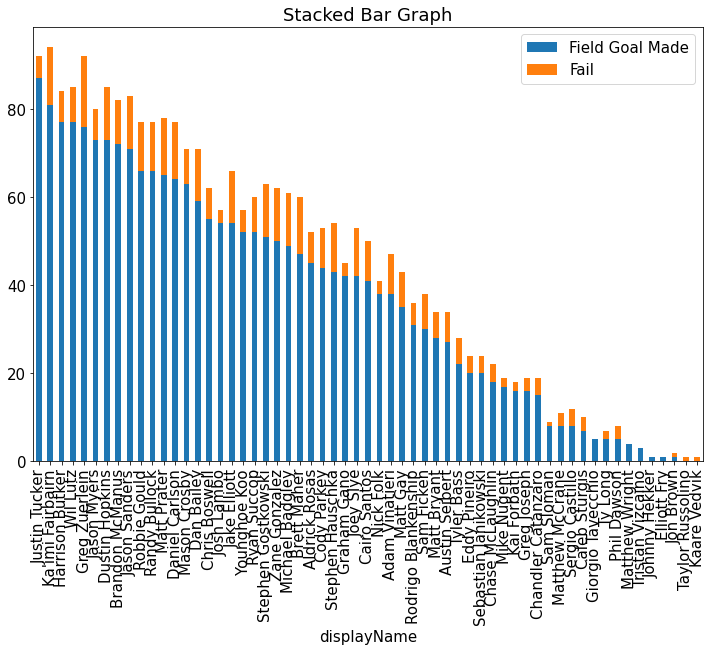

In [84]:
df = players_stat[['displayName', 'Field Goal Made','Fail']]
df.plot(
    x = 'displayName',
    kind = 'bar',
    stacked = True,
    title = 'Stacked Bar Graph',
    mark_right = True)

In [116]:
players_stat[['displayName','Field Goal Made','Total Attemp','FG %','KickLength<20','KickLength20-29','KickLength30-39','KickLength40-49','KickLength50-59','KickLength60-69','Max KL Made']]

displayName  Field Goal Made  Total Attemp        FG %  \
0          Justin Tucker               87            92   94.565217   
1       Ka'imi Fairbairn               81            94   86.170213   
2        Harrison Butker               77            84   91.666667   
3               Wil Lutz               77            85   90.588235   
4          Greg Zuerlein               76            92   82.608696   
5            Jason Myers               73            80   91.250000   
6         Dustin Hopkins               73            85   85.882353   
7        Brandon McManus               72            82   87.804878   
8          Jason Sanders               71            83   85.542169   
9           Robbie Gould               66            77   85.714286   
10         Randy Bullock               66            77   85.714286   
11           Matt Prater               65            78   83.333333   
12        Daniel Carlson               64            77   83.116883   
13          Mason Crosby               63            71   88.732394   
14            Dan Bailey               59            71   83.098592   
15         Chris Boswell               55            62   88.709677   
16            Josh Lambo               54            57   94.736842   
17          Jake Elliott               54            66   81.818182   
18          Younghoe Koo               52            57   91.228070   
19           Ryan Succop               52            60   86.666667   
20    Stephen Gostkowski               51            63   80.952381   
21         Zane Gonzalez               50            62   80.645161   
22       Michael Badgley               49            61   80.327869   
23           Brett Maher               47            60   78.333333   
24         Aldrick Rosas               45            52   86.538462   
25           Cody Parkey               44            53   83.018868   
26      Stephen Hauschka               43            54   79.629630   
27           Graham Gano               42            45   93.333333   
28             Joey Slye               42            53   79.245283   
29          Cairo Santos               41            50   82.000000   
30             Nick Folk               38            41   92.682927   
31        Adam Vinatieri               38            47   80.851064   
32              Matt Gay               35            43   81.395349   
33   Rodrigo Blankenship               31            36   86.111111   
34            Sam Ficken               30            38   78.947368   
35           Matt Bryant               28            34   82.352941   
36        Austin Seibert               27            34   79.411765   
37            Tyler Bass               22            28   78.571429   
38          Eddy Pineiro               20            24   83.333333   
39  Sebastian Janikowski               20            24   83.333333   
40      Chase McLaughlin               18            22   81.818182   
41           Mike Nugent               17            19   89.473684   
42           Kai Forbath               16            18   88.888889   
43           Greg Joseph               16            19   84.210526   
44    Chandler Catanzaro               15            19   78.947368   
45            Sam Sloman                8             9   88.888889   
46       Matthew McCrane                8            11   72.727273   
47       Sergio Castillo                8            12   66.666667   
48         Caleb Sturgis                7            10   70.000000   
49     Giorgio Tavecchio                5             5  100.000000   
50               Ty Long                5             7   71.428571   
51           Phil Dawson                5             8   62.500000   
52        Matthew Wright                4             4  100.000000   
53      Tristan Vizcaino                3             3  100.000000   
54         Johnny Hekker                1             1  100.000000   
55           Elliott Fry             

In [115]:
players_stat[("Field Goal Made")]=players_stat[("Field Goal Made")].astype(int)
players_stat[("Fail")]=players_stat[("Fail")].astype(int)
players_stat[("Total Attemp")]=players_stat[("Total Attemp")].astype(int)
players_stat[("Max KL Made")]=players_stat[("Max KL Made")].astype(int)
#players_stat[("age")]=players_stat[("age")].astype(int)

players_stat

nflId  height  weight  birthDate           collegeName Position  \
0   39470  185.42   83.01 1989-11-21                 Texas        K   
1   43846  182.88   83.01 1994-01-29                  UCLA        K   
2   45046  193.04   92.99 1995-07-14          Georgia Tech        K   
3   43689  180.34   83.46 1994-07-07         Georgia State        K   
4   38701  182.88   86.64 1987-12-27      Missouri Western        K   
5   41175  177.80   86.18 1991-05-12                Marist        K   
6   40125  187.96   92.08 1990-10-01         Florida State        K   
7   40276  190.50   91.17 1991-07-25                Temple        K   
8   46298  180.34   84.37 1995-11-16            New Mexico        K   
9   30403  182.88   86.18 1982-12-06            Penn State        K   
10  38691  175.26   95.25 1989-12-16         Texas A&amp;M        K   
11  31446  177.80   91.17 1984-08-10       Central Florida        K   
12  46236  195.58   97.52 1995-01-23                Auburn        K   
13  32386  185.42   93.89 1984-09-03              Colorado        K   
14  38134  182.88   86.18 1988-01-26        Oklahoma State        K   
15  41953  187.96   83.91 1991-03-16                  Rice        K   
16  43068  182.88   97.52 1990-11-19         Texas A&amp;M        K   
17  44966  175.26   75.75 1995-01-21               Memphis        K   
18  45576  177.80   88.45 1994-08-03      Georgia Southern        K   
19  34707  187.96   98.88 1986-09-19        South Carolina        K   
20  30932  185.42   97.52 1984-01-28               Memphis        K   
21  45037  182.88   91.63 1995-05-07         Arizona State        K   
22  46342  177.80   83.01 1995-07-28                 Miami        K   
23  40775  185.42   83.91 1989-11-21              Nebraska        K   
24  43937  190.50  100.24 1994-12-30       Southern Oregon        K   
25  41688  182.88   86.18 1992-02-19                Auburn        K   
26  33469  193.04   95.25 1985-06-29  North Carolina State        K   
27  35102  187.96   91.63 1987-04-09         Florida State        K   
28  48337  180.34   96.62 1996-04-10         Virginia Tech        K   
29  41991  172.72   72.57 1991-11-18                Tulane        K   
30  32371  185.42  100.70 1984-11-05               Arizona        K   
31  21213  182.88   96.16 1972-12-28    South Dakota State        K   
32  47928  182.88  105.23 1994-03-15                  Utah        K   
33  52751  185.42   86.64 1997-01-29               Georgia        K   
34  44240  185.42   87.09 1992-12-14            Penn State        K   
35  27091  175.26   92.08 1975-05-29                Baylor        K   
36  47953  175.26   97.07 1996-11-15              Oklahoma        K   
37  52596  177.80   83.91 1997-02-14      Georgia Southern        K   
38  46426  180.34   80.74 1995-09-13               Florida        K   
39  25326  185.42  117.03 1978-03-02         Florida State        K   
40  48488  180.34   84.82 1996-04-09              Illinois        K   
41  29874  177.80   86.18 1982-03-02            Ohio State        K   
42  38220  180.34   89.36 1987-09-02                  UCLA        K   
43  46634  182.88   95.25 1994-08-04      Florida Atlantic        K   
44  41736  190.50   90.72 1991-02-26               Clemson        K   
45  52656  172.72   92.99 1997-09-19             Miami, O.        K   
46  46663  177.80   74.84 1994-09-08          Kansas State        K   
47  42112  180.34   88.45 1990-11-01    West Texas A&amp;M        K   
48  40114  175.26   87.09 1989-08-09               Florida        K   
49  38851  177.80   82.55 1990-07-16            California        K   
50  42663  187.96   92.99 1993-04-06    Alabama-Birmingham        P   
51  23860  180.34   90.72 1975-01-23                 Texas        K   
52  48329  182.88   81.19 1996-03-22       Central Florida        K   
53  47590  187.96   92.99 1996-07-31            Washington        K   
54  38815  195.58  109.32 1990-02-08          Oregon State        P   
55  47423  182.88   77.11 19